In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
import numpy as np
import random

%matplotlib inline
sns.set()

In [3]:
df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep="\t")

/tmp/ipykernel_718/2821215940.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep="\t")


In [4]:
df.shape

(320772, 162)

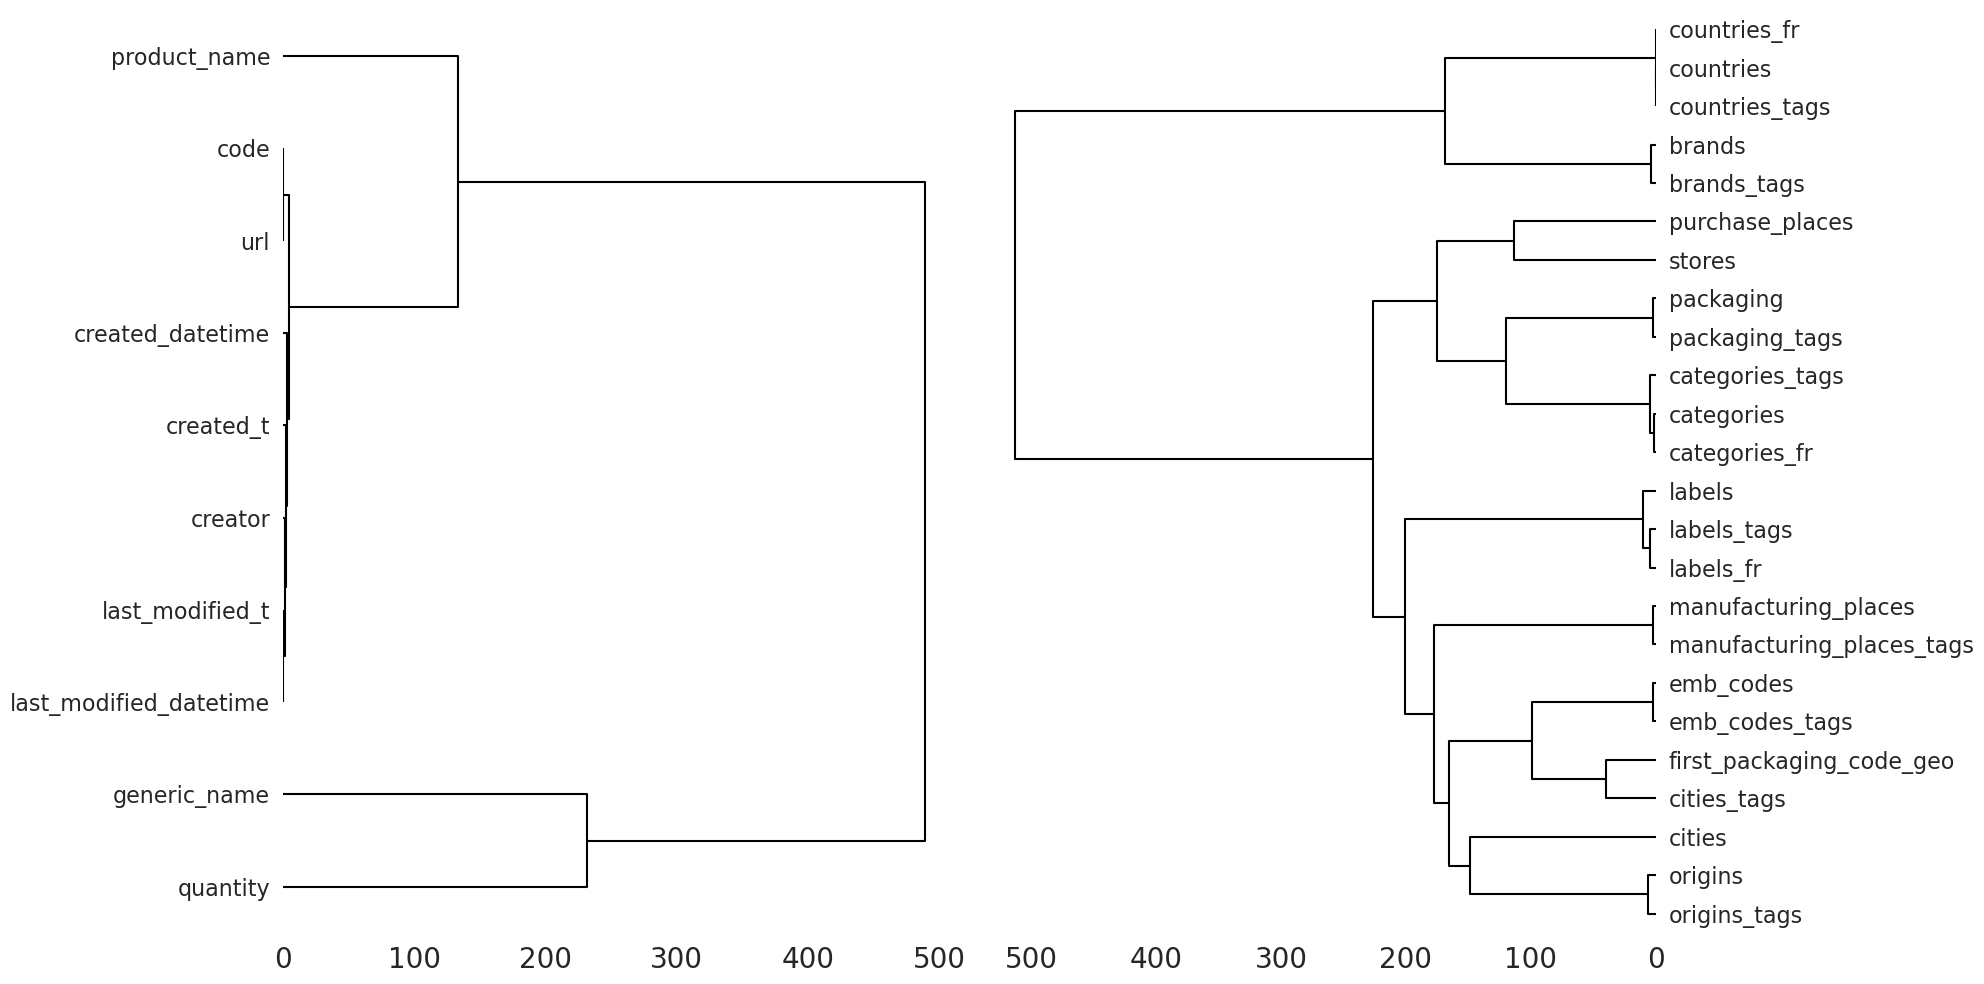

In [5]:
fig = plt.figure(figsize=(20, 10))


msno.dendrogram(df.loc[:, "code":"quantity"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "packaging":"countries_fr"], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

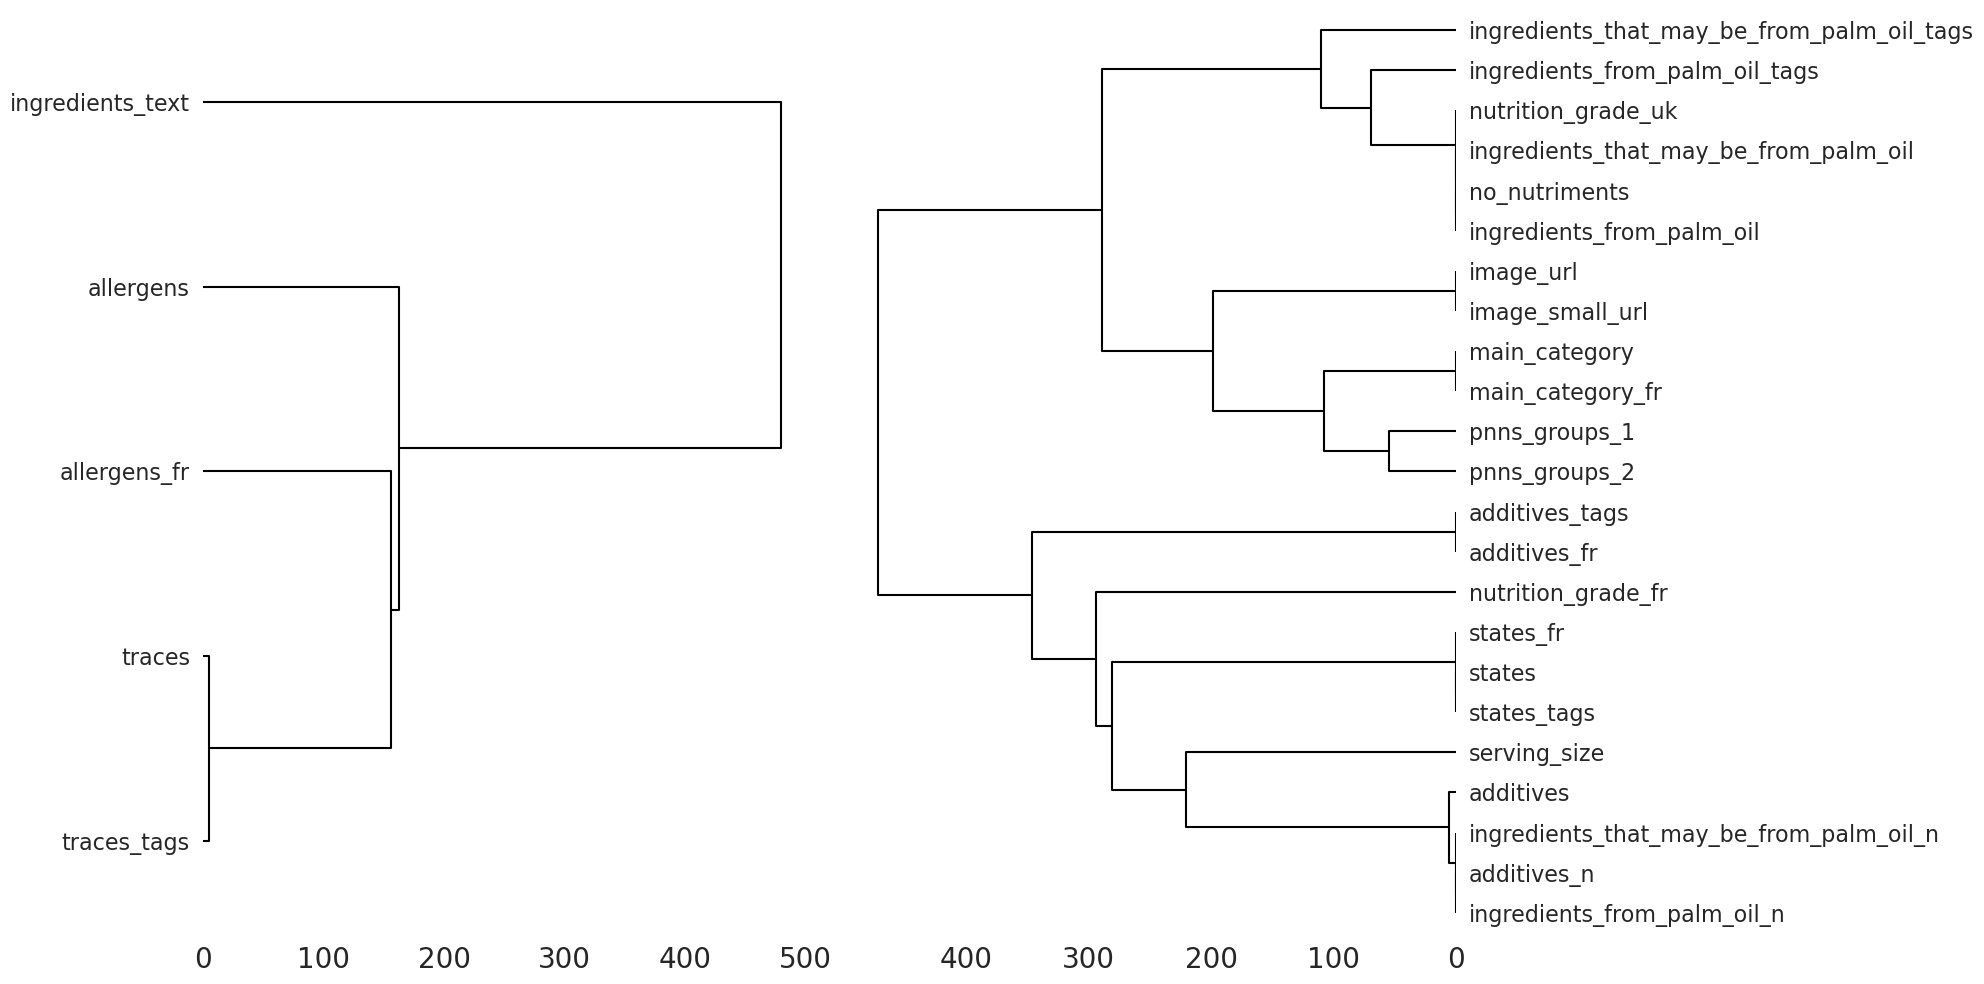

In [6]:
fig = plt.figure(figsize=(20, 10))


msno.dendrogram(df.loc[:, "ingredients_text":"traces_tags"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "serving_size":"image_small_url"], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

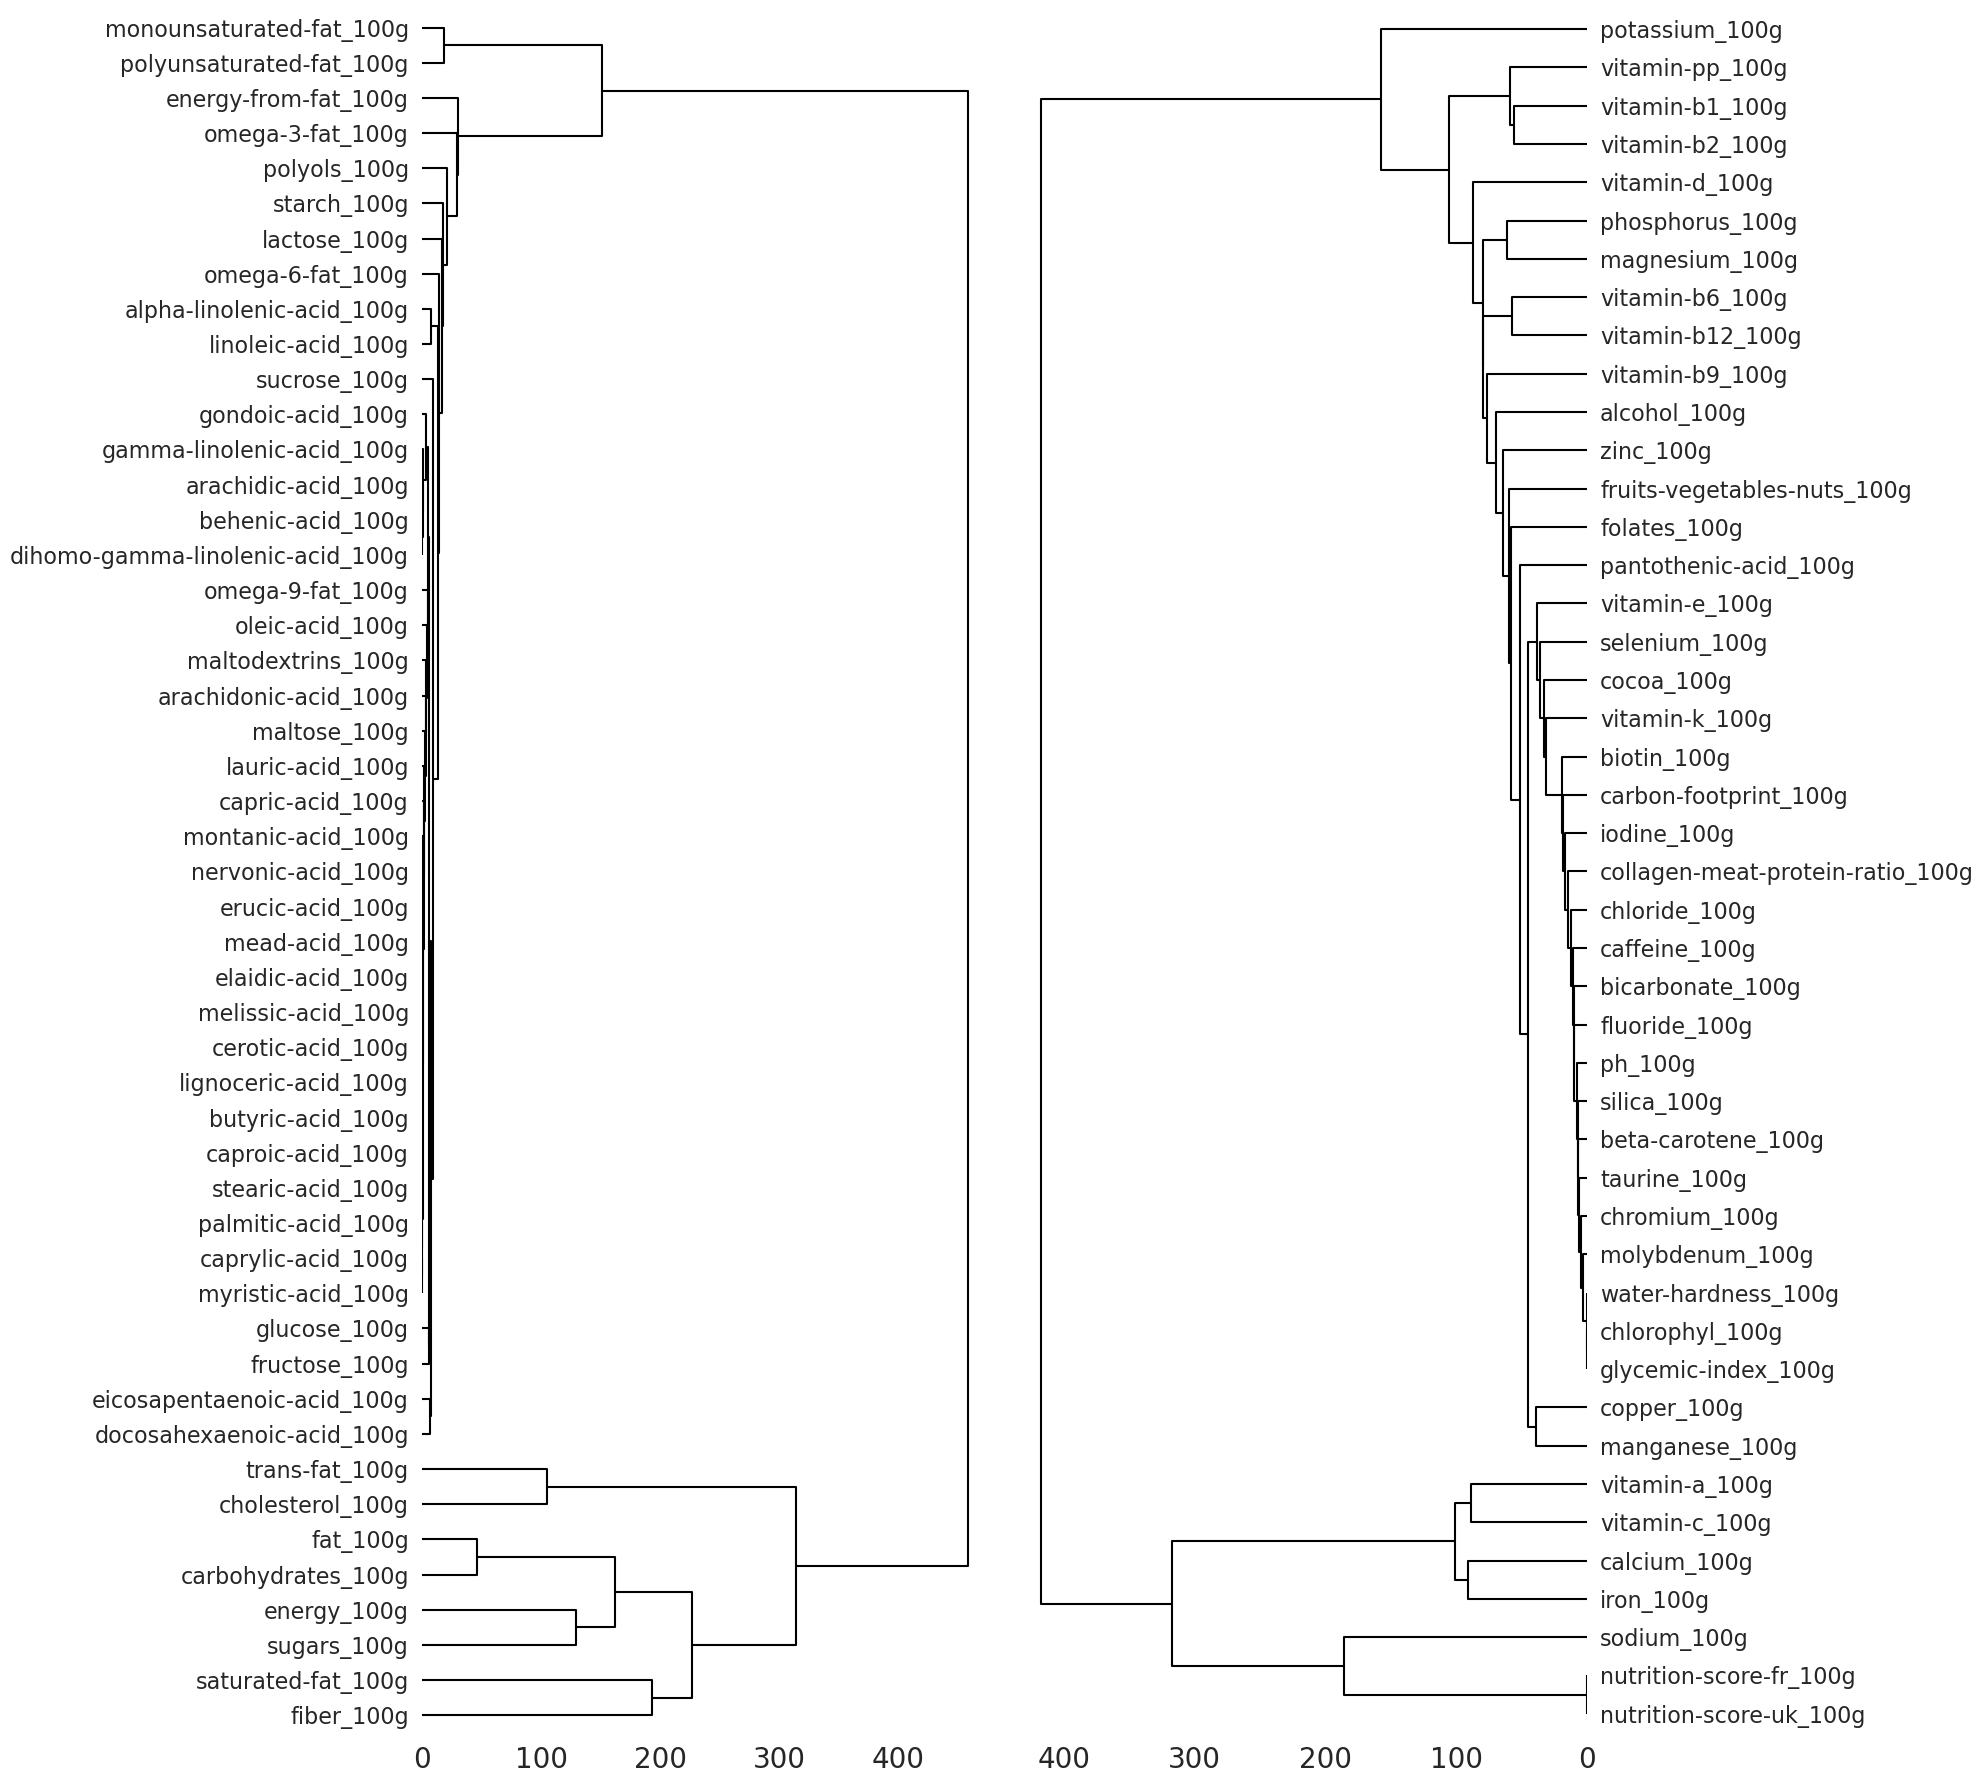

In [7]:
fig = plt.figure(figsize=(20, 18))


msno.dendrogram(df.loc[:, "energy_100g":"fiber_100g"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "sodium_100g":], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

## Definition of features and target

In [8]:
target = "main_category"

feats = [
    "creator",
    "ingredients_text",
    "countries_tags",
    "brands",
    "nutrition-score-uk_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "energy_100g",
]

In [9]:
from collections import Counter
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

sns.set()

## Functions

In [10]:
def occurences(df, cats):
    fig = plt.figure(figsize=(6 * len(cats), 8))
    for i, cat in enumerate(cats):
        fig.add_subplot(1, len(cats), i + 1)

        outliers_1 = df[cat].value_counts() == 1
        outliers_2 = df[cat].value_counts() == 2
        non_outliers = ~(outliers_1 | outliers_2)

        labels = ['More than twice', "Twice", 'Once']
        sizes = [sum(non_outliers), sum(outliers_2), sum(outliers_1)]

        plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(f'Categories occurrence in "{cat}"')
    plt.tight_layout()
    plt.show()

In [11]:
def filter_top_labels(df, col, n):
    print(f'Top {n} {col}: {df[col].value_counts().nlargest(n).index.tolist()}')
    return df[df.isin(df[col].value_counts().nlargest(n).index)[col] == True]

In [12]:
def n_missing(series): 
    return len(series.index) - series.count()

## Classes

In [13]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features=None, target=None):
        self.features = features
        self.target = target

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop rows with missing target values, select specified features and target, and drop duplicates
        X_selected = X.dropna(subset=self.target)[self.features].drop_duplicates(subset=self.features)
        return X_selected

In [14]:
class OutlierToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, iqr=False):
        self.iqr = iqr
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):   
        X_copy = X.copy() 
        if self.iqr:
            q1, q3 = np.percentile(X, [25, 75])
            lower_bound = q1 - 1.5 * (q3 - q1)
            upper_bound = q3 + 1.5 * (q3 - q1)
            X_copy[X < lower_bound] = np.nan
            X_copy[X > upper_bound] = np.nan    
        elif str(X.dtype).startswith('float'):
            X_copy[X > 100] = np.nan
        return X_copy

In [15]:
class ContinuousImputer(BaseEstimator, TransformerMixin):
    def __init__(self, reverse_transform):
        self.reverse_transform = reverse_transform

    def fit(self, X, y=None):
        return self    
    
    def transform(self, X):
        missing_indices = X.index[X.isna()]
        imputed_series = X.copy()
        imputed_series[missing_indices] = self.reverse_transform
        return imputed_series

In [16]:
class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_cat):
        self.n_cat = n_cat

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Impute missing values using a random variable
        def random_imputing(row, choices, probs):
            if pd.isnull(row):
                return np.random.choice(choices, p=probs)
            else:
                return row

        # Calculate value counts of non-null values
        vc = X.dropna().value_counts()

        # Map top categories, treat others as 'other', and calculate normalized value counts
        top = X.map(
            {
                i: i if i in vc[: self.n_cat].index.tolist() else "misc"
                for i in vc.index.tolist()
            }
        )
        top_vc = top.value_counts(normalize=True)

        # Extract choices and corresponding probabilities
        self.choices = top_vc.index.tolist()
        self.probs = pd.to_numeric(top_vc.values, errors="coerce")

        # Apply the imputation function to the Series
        X_imputed = self.top.apply(
            random_imputing,
            args=(
                self.choices,
                self.probs,
            ),
        )
        return X_imputed

In [17]:
class LabelFormatter(BaseEstimator, TransformerMixin):

    def __init__(self, to_format=None):
        self.to_format = to_format

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Filter and extract nouns from a given sentence.
        def filter_tokens(sentence):
            if pd.notna(sentence):
                tokens = word_tokenize(sentence.lower())
                words = {
                    word for word in tokens
                    # Extract nouns that do not contain specific characters
                    if all(char not in word for char in "%'/:")
                    and len(word) > 2
                }
                return words
            else:
                return np.nan

        # Apply the filter_tokens function to extract and filter nouns from sentences
        if isinstance(X, pd.DataFrame):
            formatted_col = X[self.to_format].apply(filter_tokens)
            X.loc[:, self.to_format] = formatted_col
        else:
            X = pd.DataFrame(X.apply(filter_tokens))
       
        return X

In [18]:
class MultiLabelEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, to_encode=None, rank=None):
        self.to_encode = to_encode
        self.rank = rank

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Function to filter words in a list based on a checklist
        def filter_words(lst, checklist):
            if pd.notna(lst):
                # Keep only words that are in the checklist
                words = {word for word in lst if word in checklist}
                return words
            else:
                return np.nan

        encoded_col = X[self.to_encode]
        # Count the occurrences of each word in the dataset
        count = Counter(
            [
                word
                for rows in encoded_col.dropna()
                for word in rows
                if word == word and "and" not in word
            ]
        )

        # Extract the most common words and their counts up to the specified rank
        self.most_common = pd.Series(
            [i[1] for i in count.most_common(self.rank)],
            index=[j[0] for j in count.most_common(self.rank)],
        )

        # Apply the filter_words function to keep only the most common words in each row
        encoded_col = encoded_col.apply(filter_words, args=(self.most_common.index,))

        # Initialize MultiLabelBinarizer and fit it with the most common words
        mlb = MultiLabelBinarizer()
        mlb.fit([self.most_common.index])

        # Transform the filtered words into binary representation
        encoded_values = mlb.transform(encoded_col.dropna()).tolist()

        # Apply the transformation to replace words with their binary representation
        encoded_col = encoded_col.apply(
            lambda x: encoded_values.pop(0) if pd.notna(x) else np.full(self.rank, np.nan)
        )

        X.loc[:, self.to_encode] = encoded_col
        return X

In [19]:
class LabelImputer(BaseEstimator, TransformerMixin):
    def __init__(self, to_impute=None):
        self.to_impute = to_impute

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        knn = KNNImputer(n_neighbors=10)
        imputed_col = knn.fit(X[self.to_impute])
        X.loc[:, self.target] = imputed_col
        return X

## EDA

In [20]:
fs = FeatureSelector(features=feats, target=target)
otn = OutlierToNaN()

selected_data = fs.fit_transform(df)

for c in selected_data.columns:
    if c.startswith('energy'):
        otn = OutlierToNaN(iqr=True)
    else:
        otn = OutlierToNaN()
    selected_data.loc[:, c] = otn.fit_transform(selected_data[c])

In [21]:
fmt = LabelFormatter()
y_ = fmt.fit_transform(df[target].dropna())[target].explode()

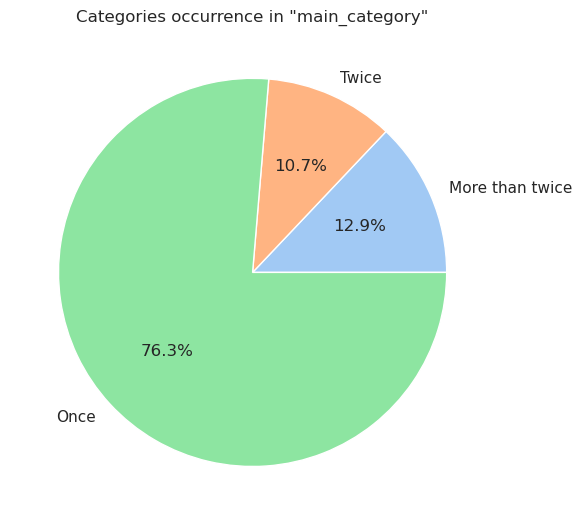

In [22]:
occurences(pd.DataFrame(y_), [target])

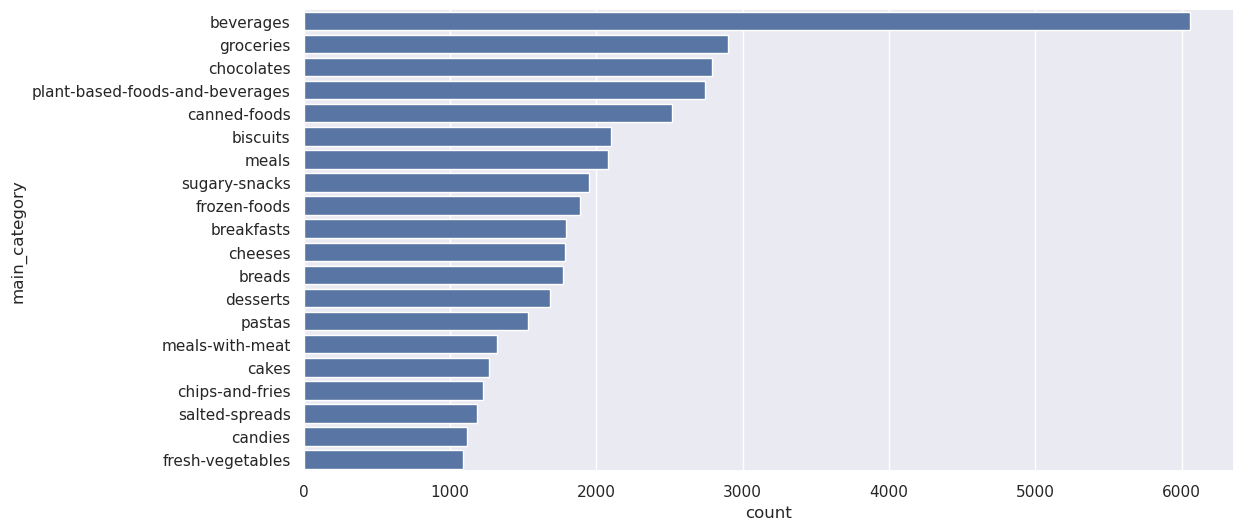

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(
    y=y_,
    order=y_.value_counts()[:20].index,
    color='b'
)
plt.show()

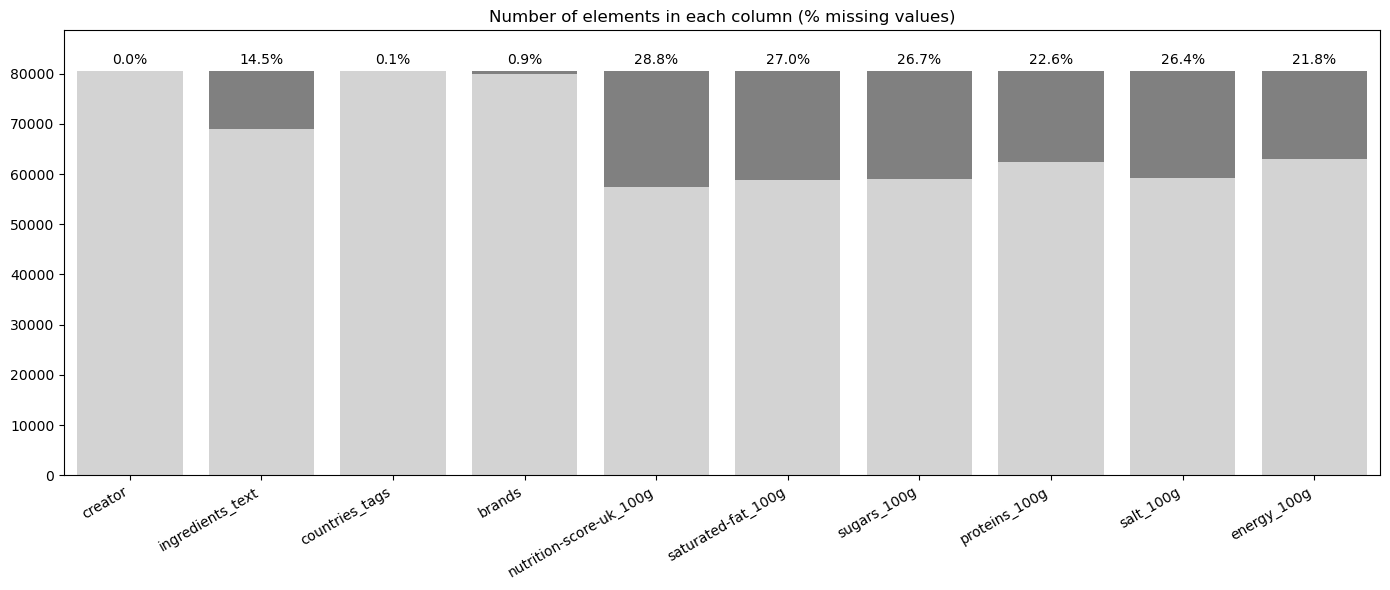

In [24]:
sns.reset_orig()
plt.figure(figsize=(14, 6))

bar_total = sns.barplot(
    x=selected_data.count().index, y=[len(selected_data)] * len(selected_data.count()), color="gray"
)
bar_elements = sns.barplot(
    x=selected_data.count().index, y=selected_data.count().values, color="lightgray"
)

for i, col in enumerate(selected_data.columns):
    bar_total.text(
        i,
        1.01 * len(selected_data),
        f"{round(n_missing(selected_data[col]) / len(selected_data) * 100, 1)}%",
        ha="center",
        va="bottom",
        color="black",
    )

bar_total.set_ylim(0, 1.1 * len(selected_data))

plt.xticks(rotation=30, ha="right")
plt.title("Number of elements in each column (% missing values)")
plt.tight_layout()
plt.show()
sns.set()

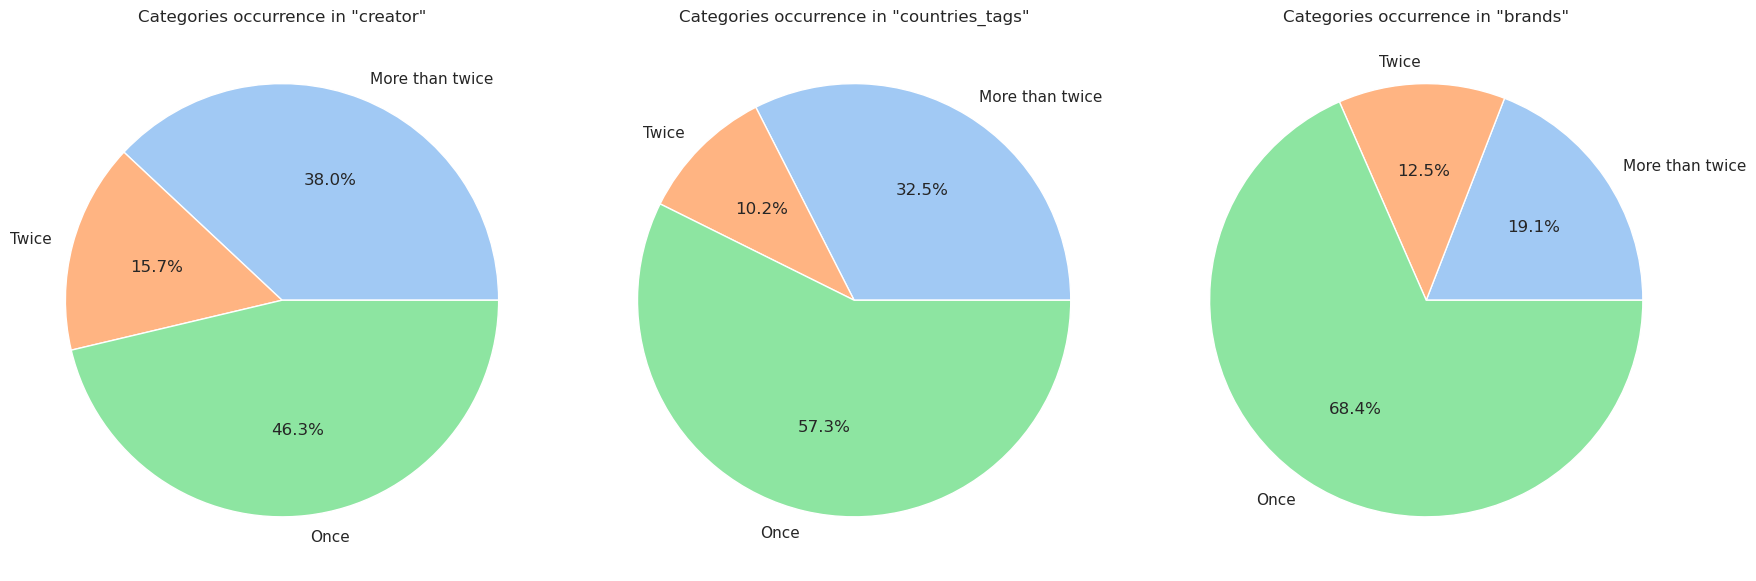

In [26]:
list_cat = ['creator', 'countries_tags', 'brands']

occurences(selected_data, list_cat)

In [27]:
numerical_data_100g = {
    label: selected_data[label][
        ~selected_data[label].isna()
        & (selected_data[label] < 100)
        & (selected_data[label] > 0)
    ] 
    for label in ["sugars_100g", "saturated-fat_100g", "proteins_100g", "salt_100g"]
}

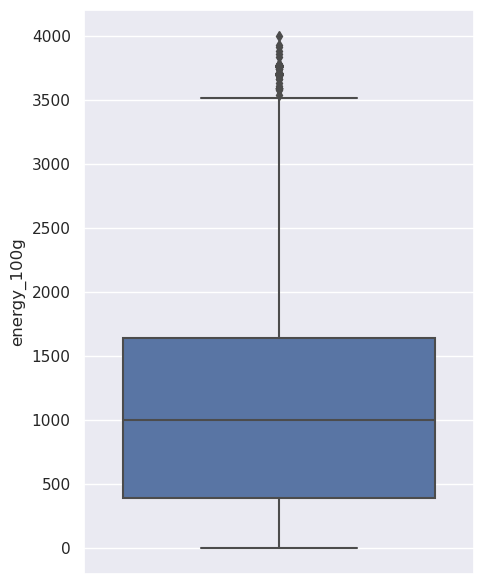

In [44]:
fig = plt.figure(figsize=(5, 6))
bounded_energy = selected_data["energy_100g"][
    (selected_data["energy_100g"] > 0) & (selected_data["energy_100g"] <= 4000)
]

sns.boxplot(y=bounded_energy)
plt.tight_layout()
plt.show()

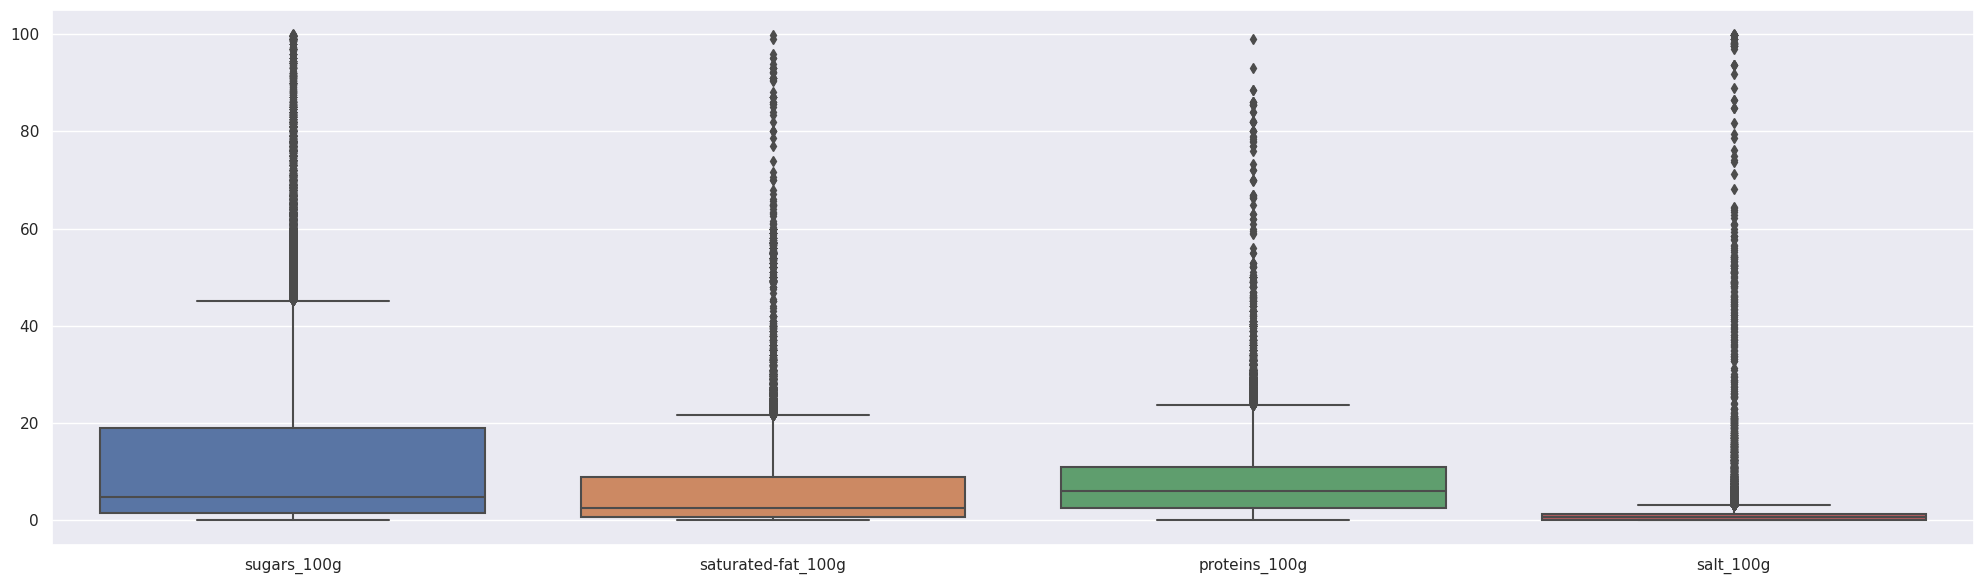

In [47]:
fig = plt.figure(figsize=(20, 6))

df_numerical_data = pd.DataFrame.from_dict(numerical_data_100g)


sns.boxplot(data=df_numerical_data)
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import norm, loggamma, f_oneway, probplot
from sklearn.preprocessing import scale

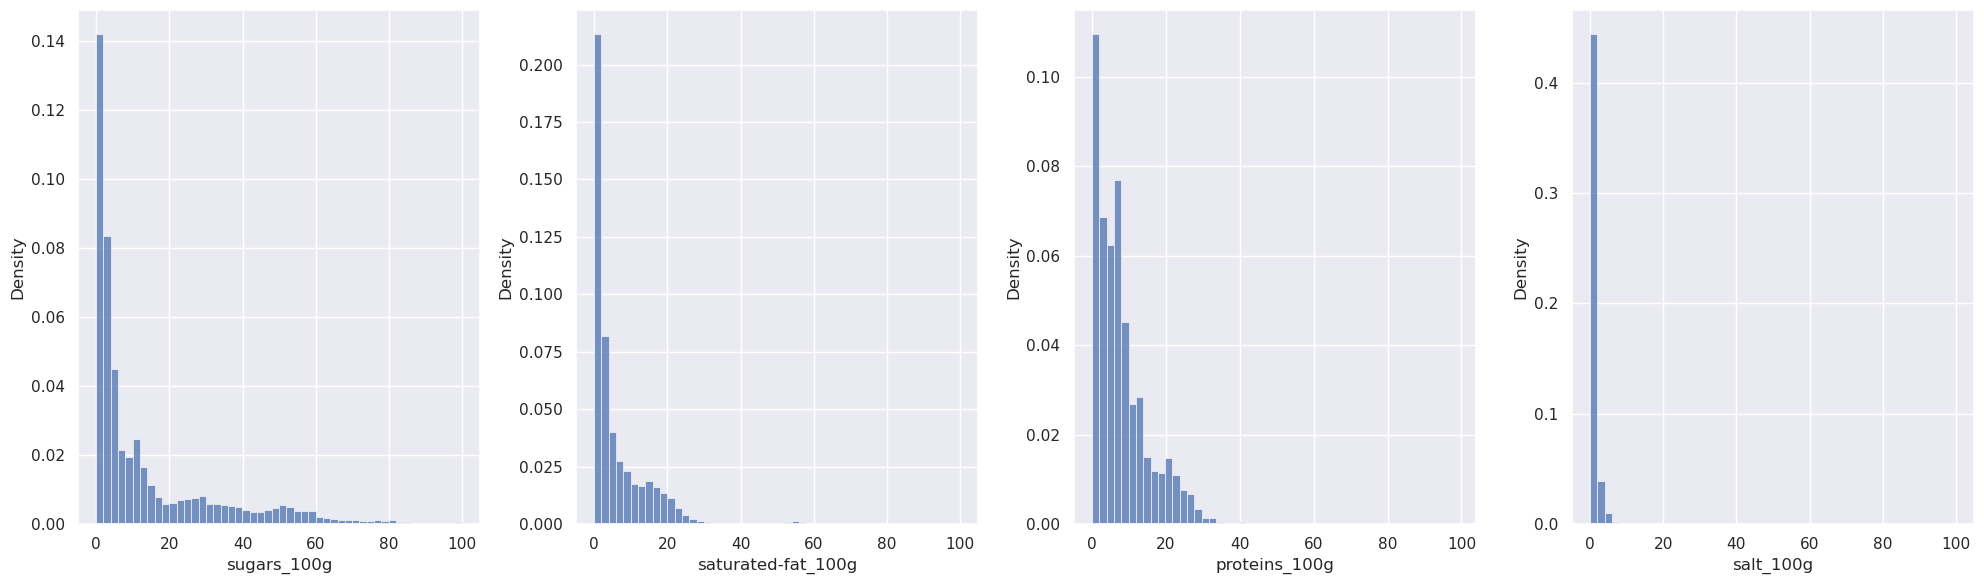

In [41]:
fig = plt.figure(figsize=(20, 6))

for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(1, len(numerical_data_100g), i + 1)
    sns.histplot(numerical_data_100g[label], bins=50, stat='density')
plt.tight_layout()
plt.show()

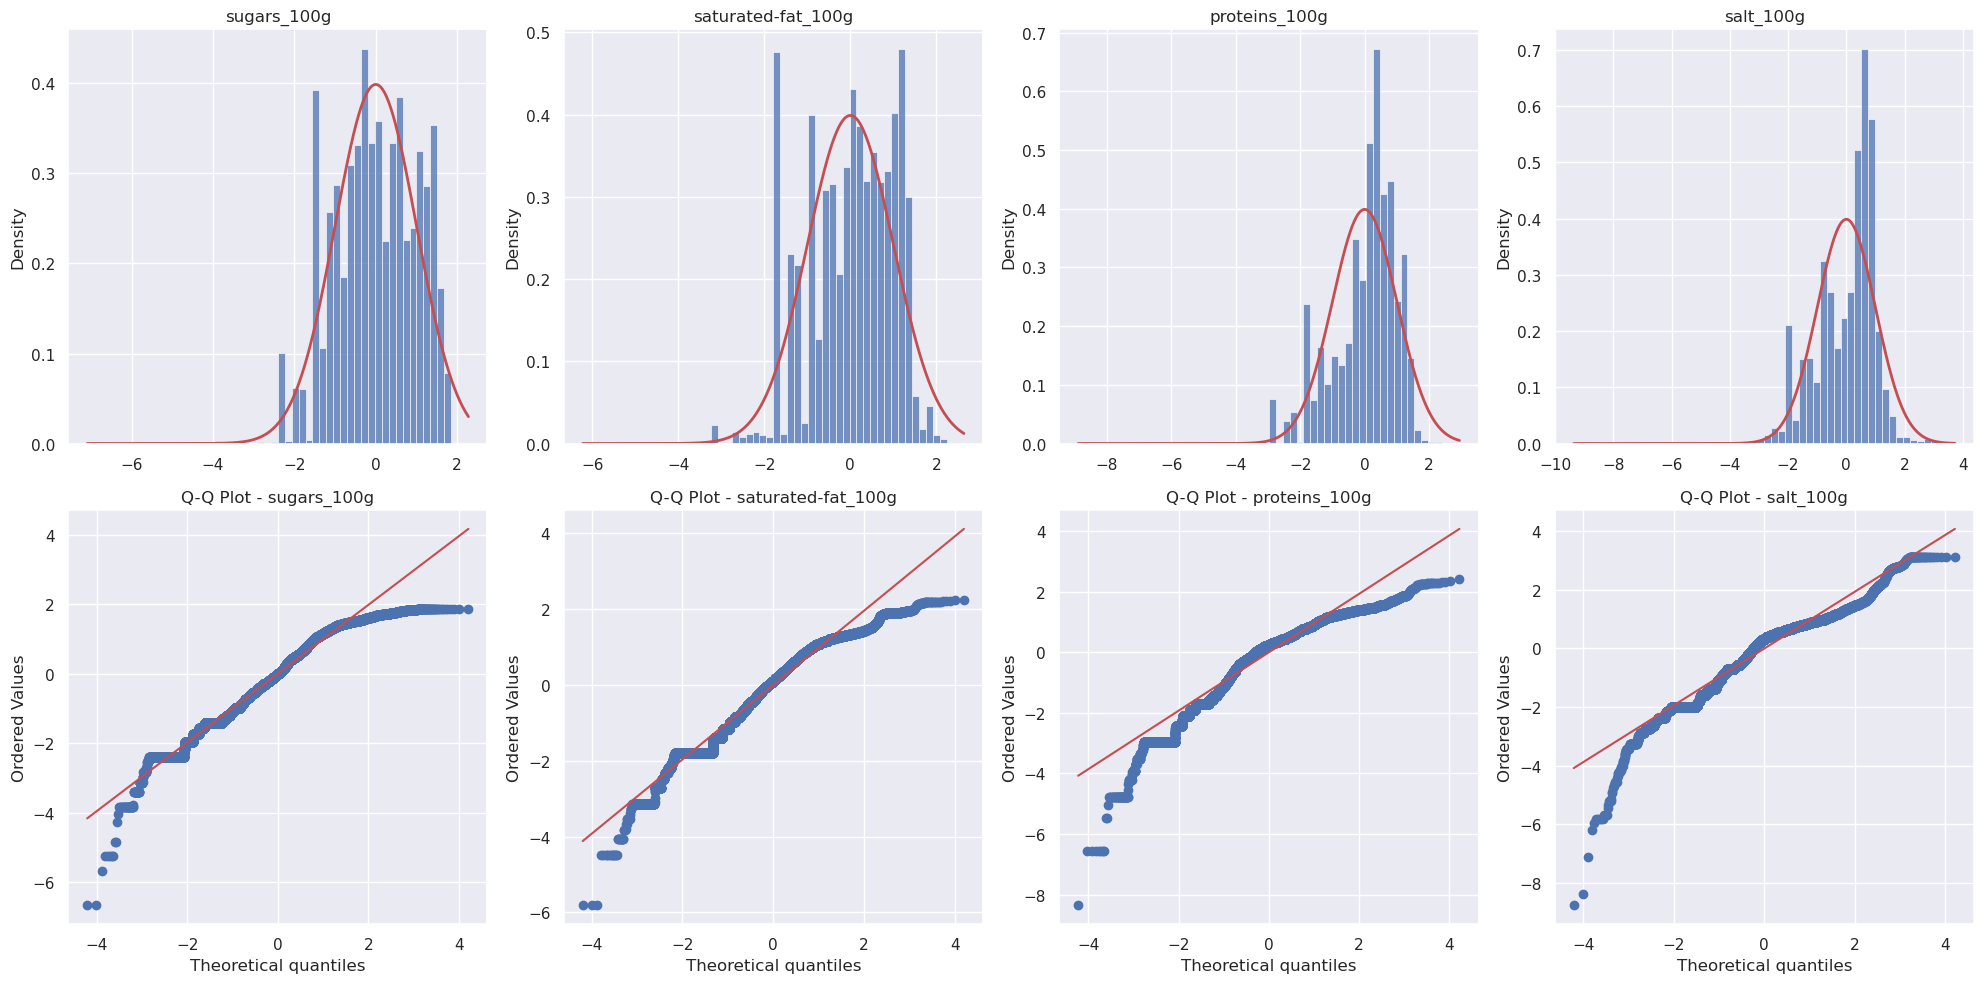

In [119]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig = plt.figure(figsize=(20, 10))

for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(2, len(numerical_data_100g), i + 1)

    log_data = numerical_data_100g[label].apply(np.log).to_numpy().reshape(-1, 1)
    scaled_data = scaler.fit_transform(log_data).flatten()
    sns.histplot(scaled_data, bins=50, stat="density")

    xmin, xmax = plt.xlim()
    x_values = np.linspace(xmin, xmax, 1000)
    params = norm.fit(scaled_data)
    n_prob = norm.pdf(x_values, *params)
    plt.plot(x_values, n_prob, "r", linewidth=2)
    plt.title(label)

    probplot(scaled_data, dist=norm, plot=fig.add_subplot(2, len(numerical_data_100g), i + 5))
    plt.title(f'Q-Q Plot - {label}')
plt.tight_layout()
plt.show()

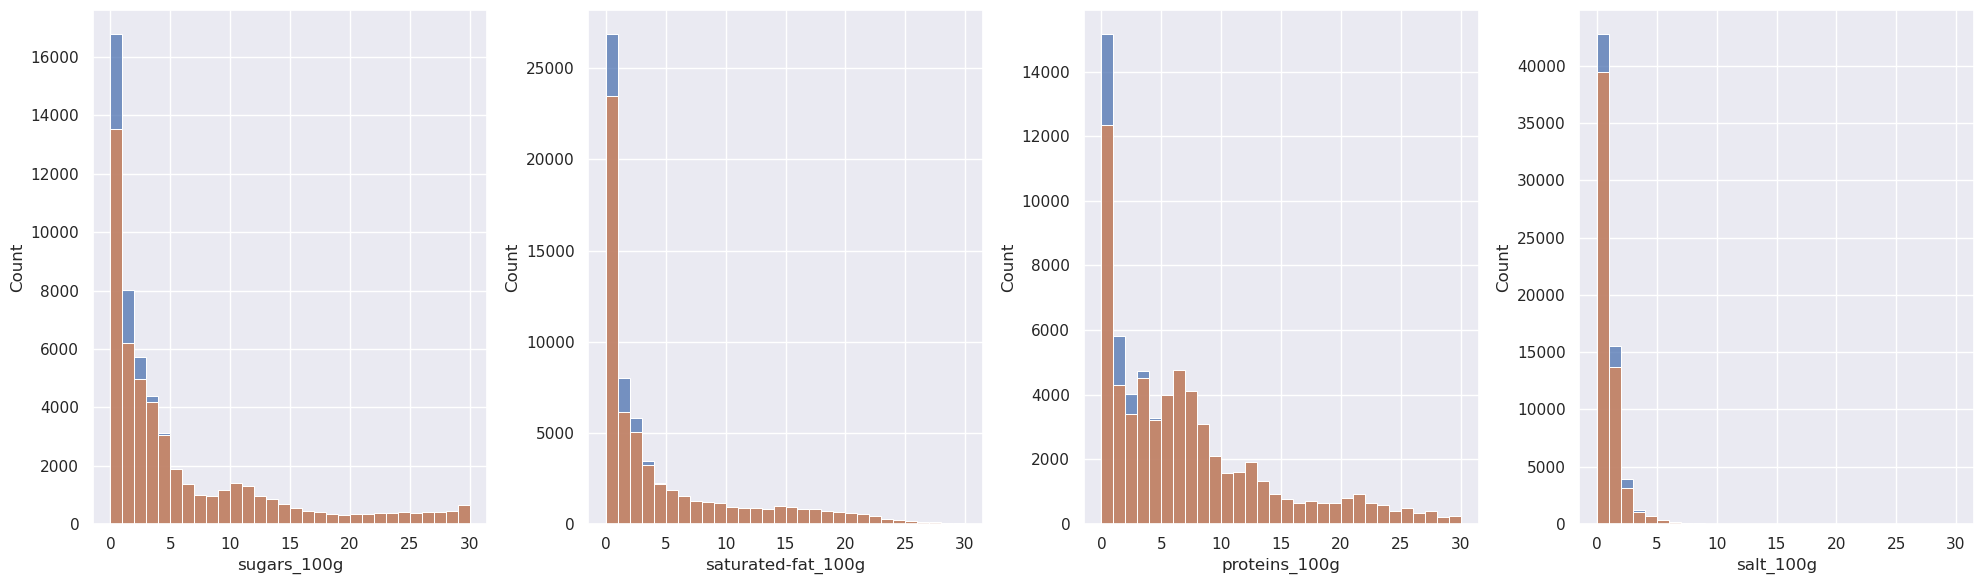

In [127]:
fig = plt.figure(figsize=(20, 6))

for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(1, 4, i + 1)
    n_miss = n_missing(selected_data[label])

    new_data = norm.rvs(*params, size=n_miss)

    reverse_transform = scaler.inverse_transform(new_data.reshape(-1, 1)).flatten()
    missing_indices = selected_data[label].index[selected_data[label].isna()]
    imputed_series = selected_data[label].copy()
    imputed_series[missing_indices] = reverse_transform

    sns.histplot(imputed_series, bins=30, binrange=[0, 30])
    sns.histplot(selected_data[label], bins=30, binrange=[0, 30])
plt.tight_layout()
plt.show()


[1.062743156355415, 0.2861639361454253, 0.288832086478825]
[-6.60215    -4.3037009  -3.80710626 ... -0.45339232  0.05051884
 -2.87779422]


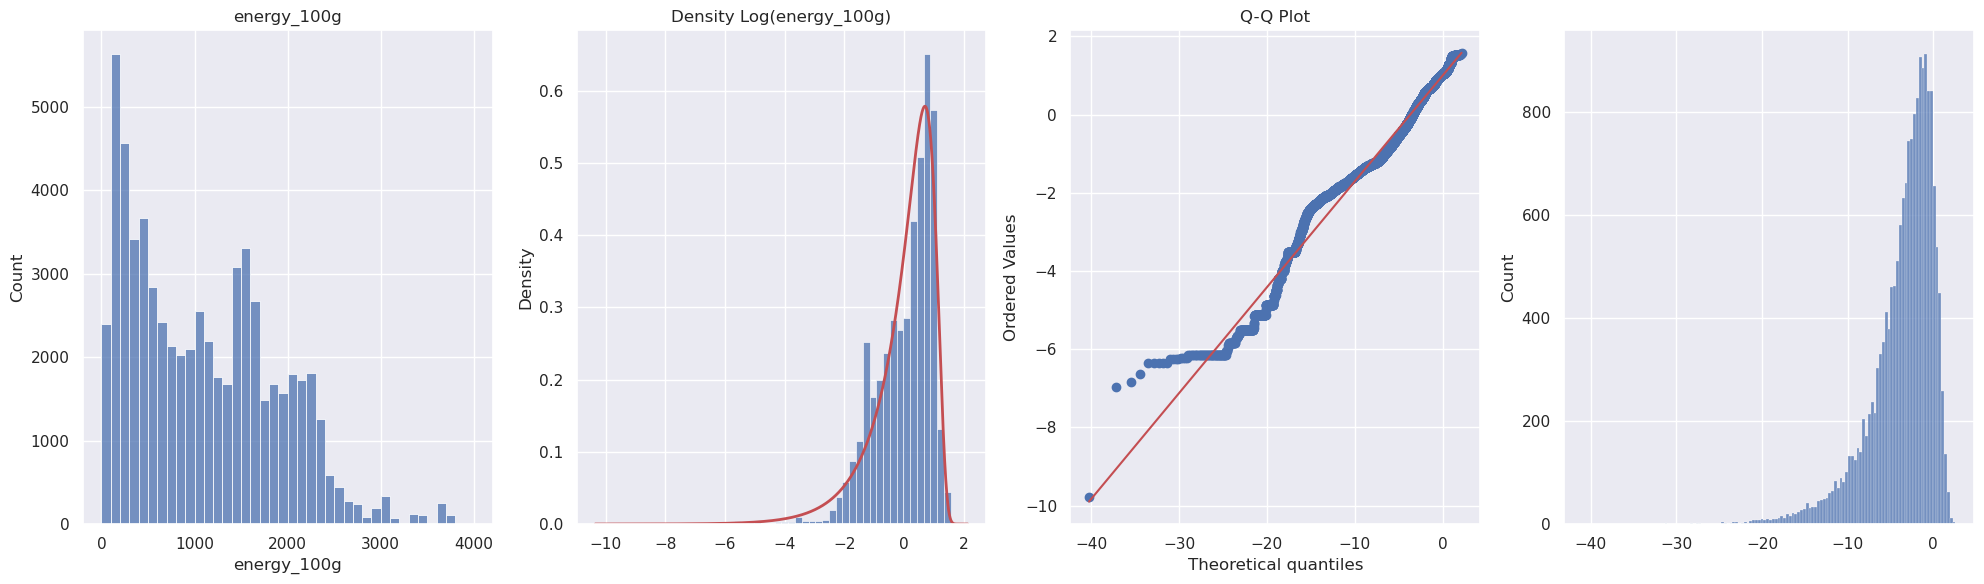

In [94]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(141)
sns.histplot(bounded_energy, bins=40)
plt.title('energy_100g')

# -------------------------------------------------------------------------------------- #

fig.add_subplot(142)
scaled_energy = scale(bounded_energy.apply(np.log))
sns.histplot(scaled_energy, stat="density", bins=50)

xmin, xmax = plt.xlim()
x_values = np.linspace(xmin, xmax, 100000)
c_, loc_, scale_ = loggamma.fit(scaled_energy)
print([loc_, c_, scale_])
n_prob = loggamma.pdf(x_values, c_, loc_, scale_)
plt.plot(x_values, n_prob, "r", linewidth=2)
plt.title('Density Log(energy_100g)')

# -------------------------------------------------------------------------------------- #

probplot(scaled_energy, sparams=(c_,), dist=loggamma, plot=fig.add_subplot(143))
plt.title('Q-Q Plot')

# -------------------------------------------------------------------------------------- #

fig.add_subplot(144)
n_miss_energy = n_missing(selected_data['energy_100g'])

reverse_loggamma = loggamma.rvs(c_, scale_, loc_, size=n_miss_energy)
sns.histplot(reverse_loggamma)
print(reverse_loggamma)

c_imp = ContinuousImputer(reverse_loggamma)
imputed_energy = c_imp.fit_transform(selected_data['energy_100g'])

#sns.histplot(imputed_energy, bins=40, binrange=[0, 4000])
#sns.histplot(bounded_energy, bins=40, binrange=[0, 4000], alpha=0.5)

# -------------------------------------------------------------------------------------- #

plt.tight_layout()
plt.show()

[1.92398026 0.86413529 2.49902085 ... 1.87539906 1.2768743  0.39931883]


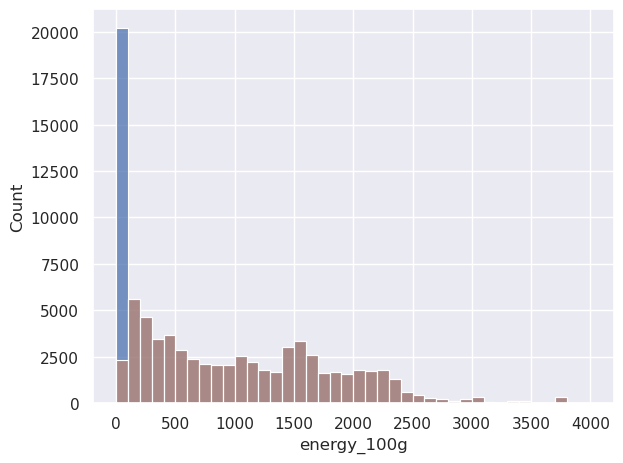

In [63]:
fig, ax = plt.subplots()


plt.tight_layout()
plt.show()

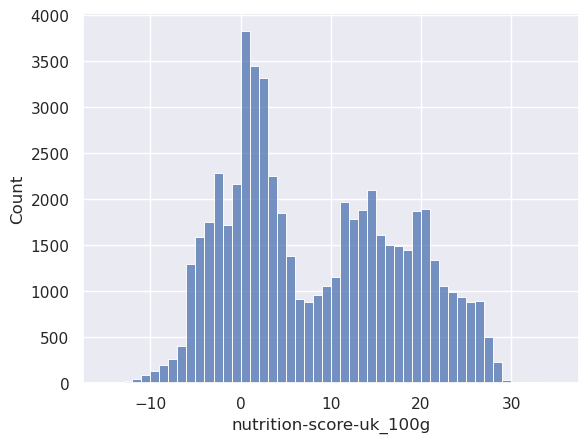

In [ ]:
sns.histplot(selected_data['nutrition-score-uk_100g'], bins=50)
plt.show()

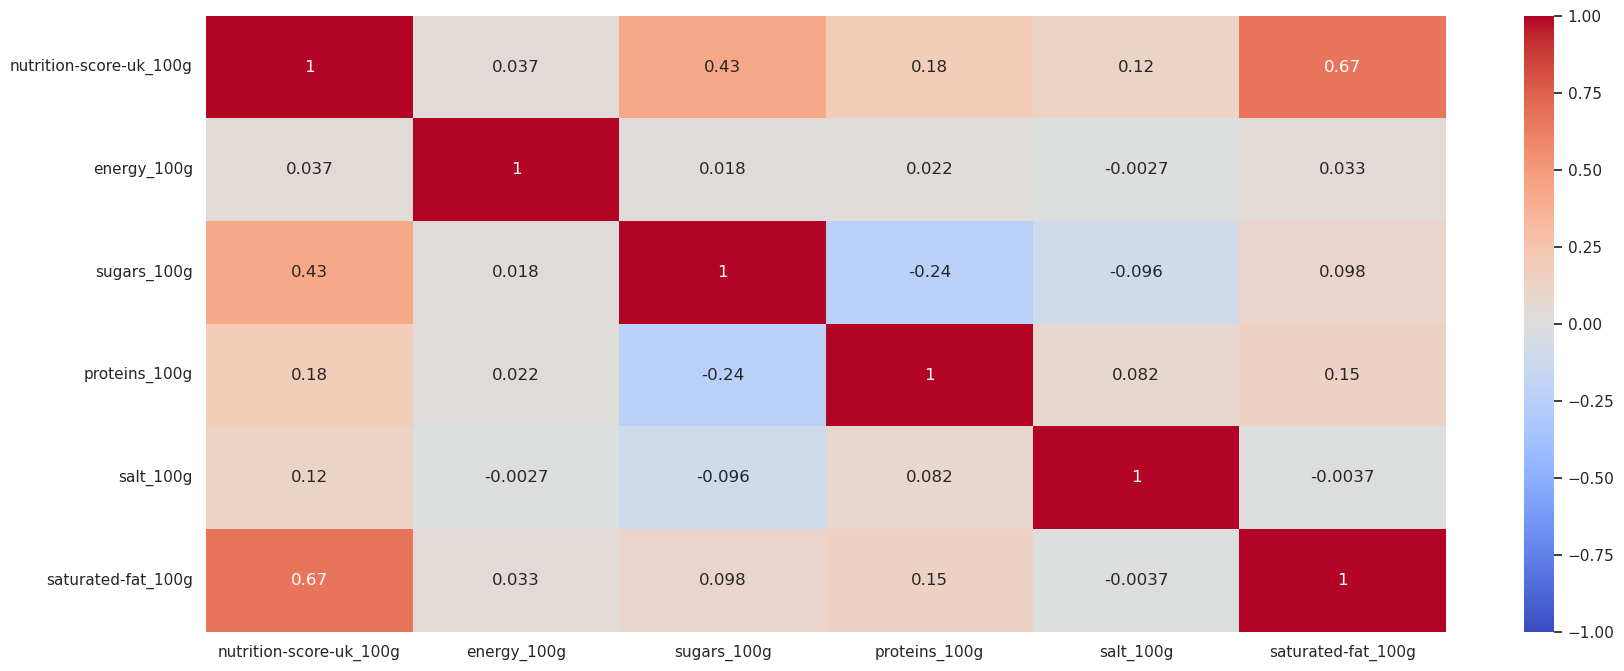

In [83]:
cm = selected_data[[
    "nutrition-score-uk_100g",
    "energy_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "saturated-fat_100g",
    ]].corr()

fig = plt.figure(figsize=(20, 8))

sns.heatmap(cm, cmap="coolwarm", vmin=-1, annot=True)

#fig.savefig('../../open_food_facts_plots/temp.png', transparent=True)
plt.show()

In [56]:
labels = [
    "energy_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "saturated-fat_100g",
]

In [82]:
fig = plt.figure(figsize=(20, 8))
data = pd.DataFrame.from_dict(numerical_data_100g).dropna()

scaled_data = scale(data.to_numpy())

pca = PCA(n_components=len(numerical_data_100g))
X_pca = pca.fit_transform(scaled_data)

components_df = pd.DataFrame(data=X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
plt.figure(figsize=(8, 6))

fig.add_subplot(121)
sns.scatterplot(x=components_df['PC1'], y=components_df['PC2'])
fig.add_subplot(122)
sns.barplot(x=range(1, len(pca.explained_variance_ratio_) + 1), y=pca.explained_variance_ratio_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

AttributeError: 'bool' object has no attribute 'all'

In [ ]:
pd.Series(pca.components_[0], index=scaled_data.columns).abs().sort_values(ascending=False)

proteins_100g         0.699759
saturated-fat_100g    0.673707
energy_100g           0.195055
sugars_100g           0.124854
salt_100g             0.053125
dtype: float64

In [ ]:
pd.Series(pca.components_[1], index=scaled_data.columns).abs().sort_values(ascending=False)

energy_100g           0.643824
salt_100g             0.535911
sugars_100g           0.488241
saturated-fat_100g    0.228786
proteins_100g         0.086996
dtype: float64

In [ ]:
filter_top_labels(selected_data, 'creator', 3)

Top 3 creator: ['openfoodfacts-contributors', 'tacite', 'sebleouf']


,creator,ingredients_text,countries_tags,brands,nutrition-score-uk_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,energy_100g
184,openfoodfacts-contributors,"Sucre, farine de _Blé_, graisse et huiles végé...",en:france,St Michel,NaN,NaN,NaN,NaN,NaN,NaN
186,openfoodfacts-contributors,NaN,en:canada,Kirkland Signature,NaN,NaN,NaN,33.900,0.735,NaN
187,tacite,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,sebleouf,"Thé noir de Chine, zestes d'oranges 7,5 %, arô...",en:france,Alice Délice,NaN,NaN,NaN,NaN,NaN,NaN
189,sebleouf,"Sirop saveur pistache 5 cl : sirop 99,16 % (su...",en:france,Alice Délice,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
320702,sebleouf,"Édulcorants : sorbitols, sucralose, acésulfame...",en:france,Fisherman's Friend,2.0,1.28,0.1,0.004,0.001,NaN
320705,openfoodfacts-contributors,NaN,en:france,"Nestlé,Nestlé Dessert",NaN,NaN,NaN,NaN,NaN,NaN
320708,openfoodfacts-contributors,"Purified water, potassium bicarbonate, sodium ...",en:united-states,KIRKLAND,NaN,NaN,NaN,NaN,NaN,NaN
320759,openfoodfacts-contributors,NaN,en:russia,Пеликан,NaN,NaN,NaN,NaN,NaN,NaN


## ANOVA

In [295]:
bins = [-float('inf'), -5, 5, 15, 25, float('inf')]
group_labels = ['Less than -5', '-5 to 5', '5 to 15', '15 to 25', 'More than 25']

grouped_scores = pd.cut(
    selected_data['nutrition-score-uk_100g'],
    bins=bins,
    labels=group_labels,
)

dict_groups = dict()

for i, nutrition_data in enumerate(numerical_data_100g):
    groups = pd.concat([
        selected_data[nutrition_data].dropna(),
        grouped_scores[~selected_data[nutrition_data].isna()]
        ],
        axis=1,
        keys=[nutrition_data, 'grouped_scores']
    ).groupby('grouped_scores')

    dict_groups[nutrition_data] = groups.apply(lambda df: df.reset_index())[nutrition_data].unstack().T
    
    st = f_oneway(
        *[
            selected_data[nutrition_data][groups.groups[label]] 
            for label in group_labels
        ]
    )
    
    print(f'{nutrition_data}: \n- statistic = {st.statistic}\n- pvalue = {st.pvalue}\n')

sugars_100g: 
- statistic = 3659.5625551366006
- pvalue = 0.0

saturated-fat_100g: 
- statistic = 13951.339187190204
- pvalue = 0.0

proteins_100g: 
- statistic = 626.6132471445836
- pvalue = 0.0

salt_100g: 
- statistic = 342.8565761458654
- pvalue = 3.4525741297878177e-292



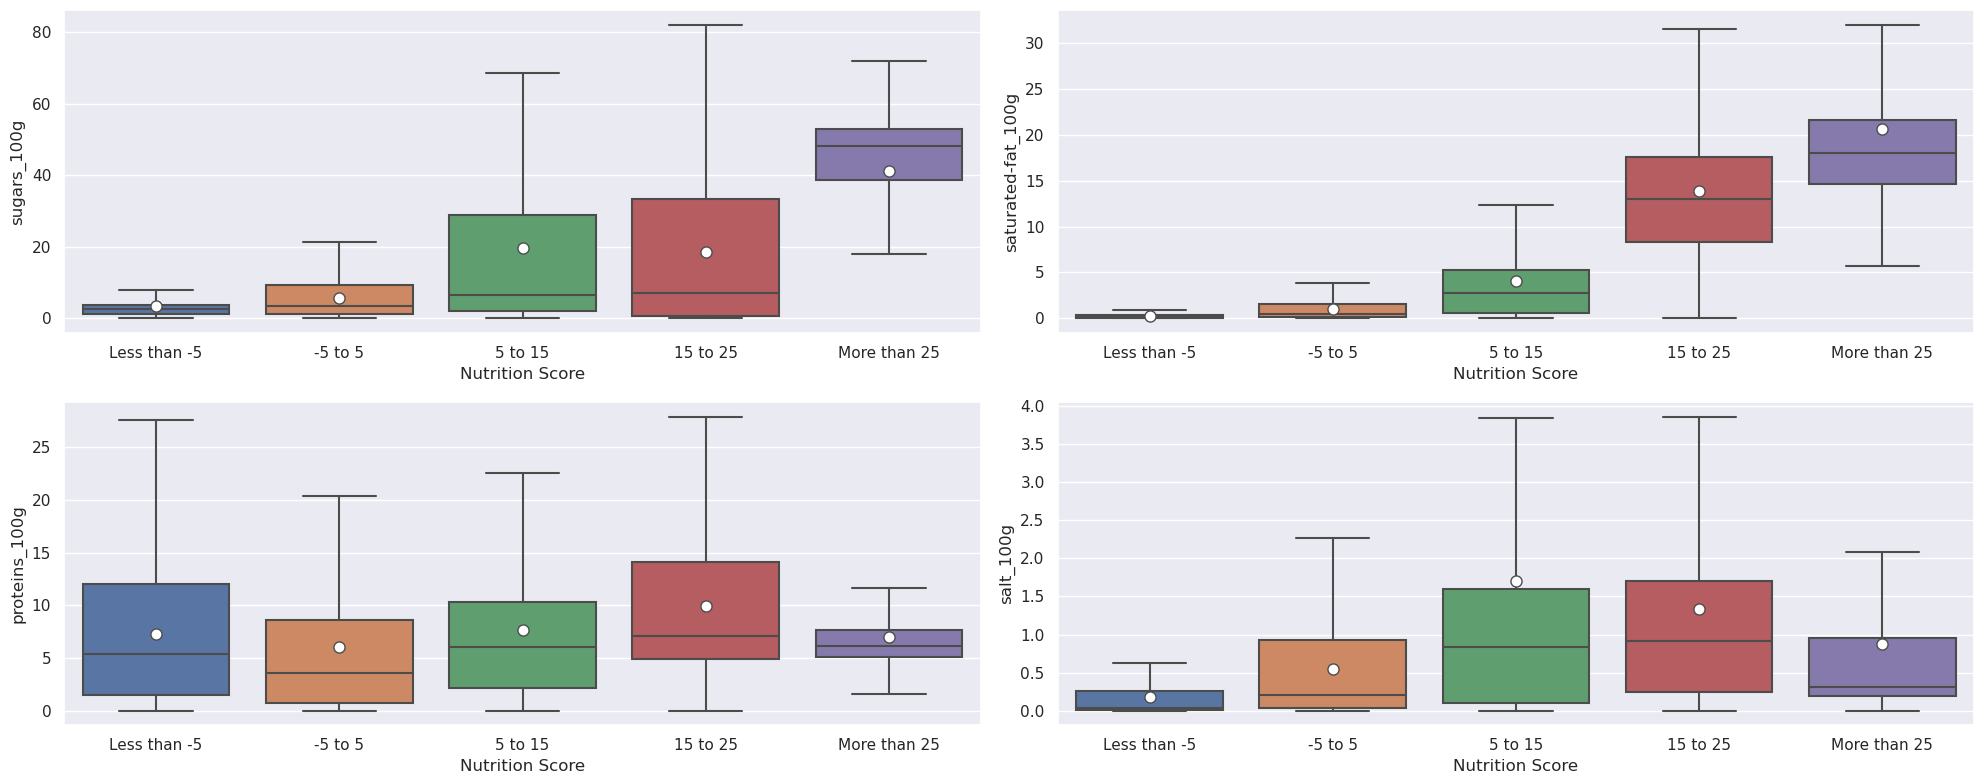

In [350]:
fig = plt.figure(figsize=(20,8))

for i, key in enumerate(dict_groups):
    fig.add_subplot(2, 2, i+1)
    sns.boxplot(data=dict_groups[key], showfliers=False, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"#4c4c4c",
                      "markersize":"8"})
    plt.xlabel('Nutrition Score')
    plt.ylabel(key)

plt.tight_layout()
plt.show()